In [3]:
# Load packages
import s3fs; import xarray as xr; import numpy as np
import pandas as pd; import dask.array as da; import ocetrac
import matplotlib.pyplot as plt; import cartopy.crs as ccrs
import warnings; import expectexception
warnings.filterwarnings('ignore')
import netCDF4 as nc; import datetime as dt; import scipy
import intake; import pprint
# Allow multiple lines per cell to be displayed without print (default is just last line)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Enable more explicit control of DataFrame display (e.g., to omit annoying line numbers)
from IPython.display import HTML

In [4]:
# load my functions
from functions import *

In [3]:
# for magic functions
%load_ext memory_profiler
%load_ext line_profiler

In [ ]:
# in order to run use apply_ocetrac_to_CESM2LE, we need this cell first
cat_url_orig = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
coll_orig = intake.open_esm_datastore(cat_url_orig)
subset = coll_orig.search(component='atm',variable='SST',frequency='month_1',experiment='historical')
member_id_list = subset.df.member_id.unique()

In [5]:
ensemble_member_val = 0
radius_val = 3

In [ ]:
%%time
detrended,blobs = apply_ocetrac_to_CESM2LE(ensemble_member_val, 0.9, radius_val, 0.75, start_val=0, end_val=1980) # ~ 6.5 minutes per ensemble member
SSTA_and_events = create_events_file(detrended, blobs)
SSTA_and_events.to_netcdf('SSTA_and_events_{}_{}.nc'.format(ensemble_member_val, radius_val))

In [ ]:
SSTA_and_events

In [6]:
%%time
# load in nino indices
nino34_first50 = xr.open_dataset('/glade/u/home/cassiacai/marine_heatwaves/data/nino34_first50.nc')
nino34_last50 = xr.open_dataset('/glade/u/home/cassiacai/marine_heatwaves/data/nino34_last50.nc')

nino4_first50 = xr.open_dataset('/glade/u/home/cassiacai/marine_heatwaves/data/nino4_first50.nc')
nino4_last50 = xr.open_dataset('/glade/u/home/cassiacai/marine_heatwaves/data/nino4_last50.nc')

# rename nino file variables
nino34_first50['nino34_ind'] = nino34_first50['SST']
nino34_first50 = nino34_first50.drop(['SST'])

nino4_first50['nino4_ind'] = nino4_first50['SST']
nino4_first50 = nino4_first50.drop(['SST'])

# nino indices for our specific ensemble member
nino34_ens0 = nino34_first50.nino34_ind[ensemble_member_val,:]
nino4_ens0 = nino4_first50.nino4_ind[ensemble_member_val,:]

CPU times: user 43.3 ms, sys: 146 µs, total: 43.5 ms
Wall time: 45.4 ms


In [7]:
%%time
# load our land mask file
land_mask = np.load('/glade/u/home/cassiacai/marine_heatwaves/data/SST_land.npy')
land_mask[land_mask > 0] = np.nan
land_mask[land_mask == 0.] = 1

CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 6.65 ms


In [8]:
SSTA_and_events =  xr.open_dataset('SSTA_and_events_0_3.nc')
total_no_mhws = number_of_mhws(SSTA_and_events)
print('There are', total_no_mhws, 'mhws in this ensemble member!')

There are 1203 mhws in this ensemble member!


In [9]:
# on one marine heatwave
mhw_id = 35
event_file = SSTA_and_events

In [16]:
duration = calc_duration(event_file, mhw_id)
cumulative_intensity, cumulative_intensity_monthly = calc_cumulativeintensity(event_file, mhw_id)
mean_intensity, mean_intensity_monthly = calc_meanintensity(event_file, mhw_id)
max_intensity, max_intensity_monthly = calc_maximumintensity(event_file, mhw_id)
std_intensity, std_intensity_monthly = calc_stdintensity(event_file, mhw_id)
coords_full, spatial_extents, max_spatial_extent, max_spatial_extent_time, mean_spatial_extent, cumulative_spatial_extent = calc_spatialextent(event_file, mhw_id)
perimeters = calc_perimeter(event_file, mhw_id)
percperivarea = calc_percperimetervsarea(spatial_extents, perimeters)
perc_sharedarea_ls = calc_compltodeform(coords_full, spatial_extents)
deform = calc_deform(perc_sharedarea_ls)
perc_imoverchull = perc_imoverchull(event_file, mhw_id)

In [ ]:
%%time

cintensmonth_dict= {}
cintens_dict = {}
for mhw_id in range(1,total_no_mhws): #total_no_mhws
    print(mhw_id)
    cumulative_intensity, cumulative_intensity_monthly = calc_cumulativeintensity(event_file, mhw_id)
    cintensmonth_dict[str(mhw_id)] = cumulative_intensity_monthly.tolist()
    cintens_dict[str(mhw_id)] = cumulative_intensity

# np.savez('cintensmonth',**cintensmonth_dict)
# np.savez('cintens',**cintens_dict)

# newfile = np.load('cintens.npz')
# for key in newfile.keys():
#     print(key)
    
# import json
# with open("your_json_file", "w") as fp:
#     json.dump(cintensmonth_dict,fp) 

cumulative_intensity_ls = []
cumulative_intensity_monthly_ls = []

for mhw_id in range(1,10): #total_no_mhws
    cumulative_intensity, cumulative_intensity_monthly = calc_cumulativeintensity(event_file, mhw_id)
    cumulative_intensity_ls.append(cumulative_intensity)
    cumulative_intensity_monthly_ls.append(cumulative_intensity_monthly_ls)

In [320]:
np.unique(append_east)

# append_east = append_east.where(append_east != 11.)

# append_east.plot.imshow(figsize=(10,5)); 

# centroid = _get_centroids(append_east)
# lon = [i[1] for i in centroid]; print(lon)
# lat = [i[0] for i in centroid]; print(lat)

# plt.pcolor(append_east,cmap='Greys')
# plt.scatter(lon, lat)
# plt.colorbar()

array([11., 12., 13.])

In [323]:
append_east == 11.

# append_east = append_east.where(replace==True, other=0)
# np.unique(append_east)

<xarray.DataArray (lat: 192, lon: 288)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 180.0 181.2 182.5 183.8 ... 535.1 536.4 537.6 538.9
    time       object 1853-02-01 00:00:00
    member_id  <U11 'r2i1021p1f1'
    quantile   float64 0.9
    month      int64 2

In [331]:
append_east


<xarray.DataArray (lat: 192, lon: 288)>
array([[11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       ...,
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 180.0 181.2 182.5 183.8 ... 535.1 536.4 537.6 538.9
    time       object 1853-02-01 00:00:00
    member_id  <U11 'r2i1021p1f1'
    quantile   float64 0.9
    month      int64 2

In [339]:
append_east

<xarray.DataArray (lat: 192, lon: 288)>
array([[11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       ...,
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 180.0 181.2 182.5 183.8 ... 535.1 536.4 537.6 538.9
    time       object 1853-02-01 00:00:00
    member_id  <U11 'r2i1021p1f1'
    quantile   float64 0.9
    month      int64 2

In [1]:
all_timesteps[0,:,:].plot.imshow()

NameError: name 'all_timesteps' is not defined

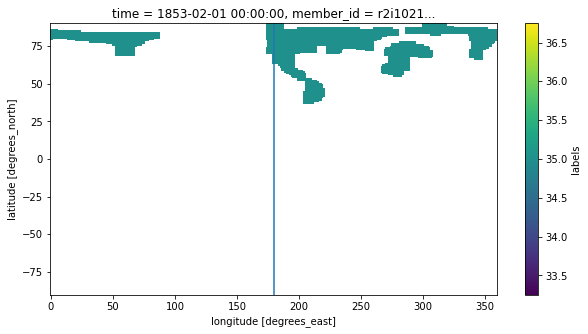

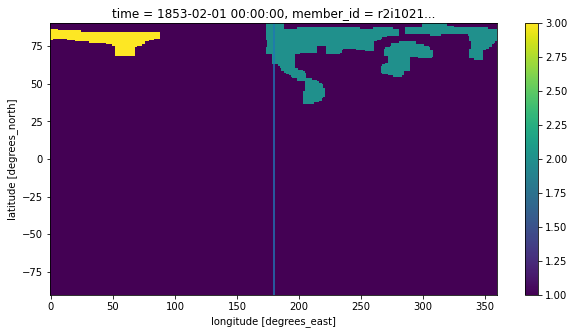

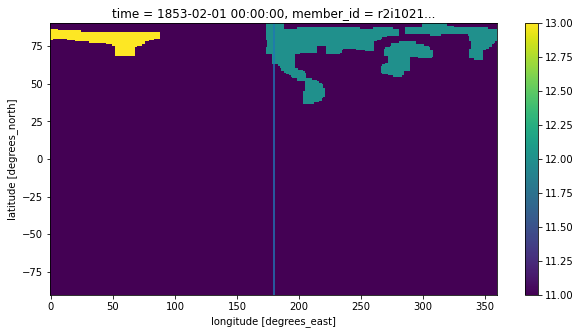

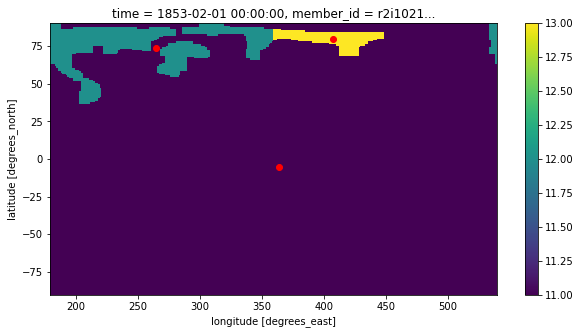

[(-5.18324607329843, 363.875), (73.97905759162303, 265.0), (79.63350785340315, 407.625)]


In [329]:
from skimage.measure import label as label_np

for_one_mhw = SSTA_and_events.where(SSTA_and_events.labels==mhw_id, drop=False)
mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
first_timestep = mhw_when[0][0]
timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)

all_timesteps = for_one_mhw.labels[timesteps_to_choose_from,:,:]

timestep = 4
# let us try one timestep
all_timesteps[timestep,:,:].plot.imshow(figsize=(10,5)); plt.axvline(x=180); plt.show() #1

sub_labels = _get_labels(all_timesteps)

def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels

sub_labels = xr.DataArray(sub_labels, dims=all_timesteps.dims, coords=all_timesteps.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan)

sub_labels[timestep,:,:].plot.imshow(figsize=(10,5)); plt.axvline(x=180); plt.show()

for p in range(1, sub_labels.shape[0]):
    sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values

sub_labels[timestep,:,:].plot.imshow(figsize=(10,5)); plt.axvline(x=180); plt.show()

centroid = []
# for s in np.arange(0, sub_labels_wrapped.shape[0]):
lx = sub_labels.isel(time=timestep)
east = lx.where(lx.lon < 180, drop=True)
east['lon'] = np.arange(360.125, 540.125, 1.25) # this value is related to your grid resolution
    # east['lon'] = np.arange(360.125, 540.125, .25)
append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
centroid = _get_centroids(append_east)
append_east.plot.imshow(figsize=(10,5)); 
plt.scatter(lon, lat, c='red')
plt.show()
print(centroid)

In [327]:
lon = [i[1] for i in centroid]; print(lon)
lat = [i[0] for i in centroid]; print(lat)

[363.875, 265.0, 407.625]
[-5.18324607329843, 73.97905759162303, 79.63350785340315]


[11. 13.]
(0, 11.0)
[11. 12.]
[False  True]


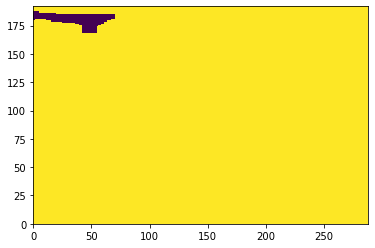

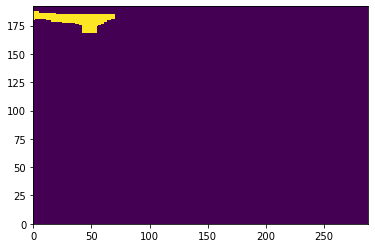

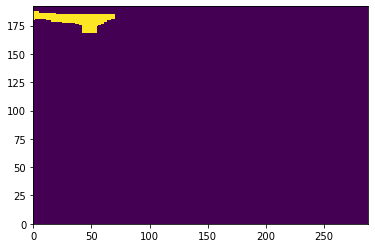

(1, 13.0)
[12.]
[False]


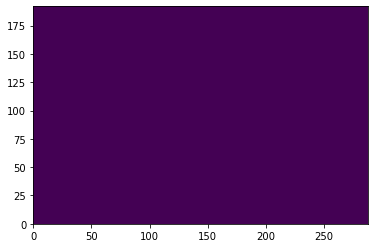

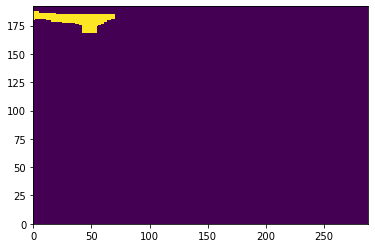

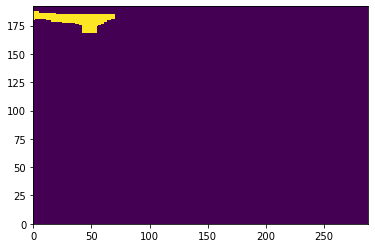

In [237]:
labels = sub_labels[timestep:(timestep+1),:,:]

first_column = labels[..., 0]
last_column = labels[..., -1]

stacked = first_column.stack(z=['time','lat'])
unique_first = np.unique(stacked[stacked.notnull()])
print(unique_first)
for i in enumerate(unique_first):
    print(i)
    first = np.where(first_column == i[1])
    last = last_column[first[0], first[1]]
    stacked = last.stack(z=['time','lat'])
    bad_labels = np.unique(stacked[stacked.notnull()])
    print(bad_labels)
    replace = np.isin(labels, bad_labels)
    print(np.unique(replace))
    plt.pcolor(replace[0,:,:]); plt.show()
    labels = labels.where(replace==False, other=i[1])
    plt.pcolor(labels[0,:,:]); plt.show()

    labels = labels.fillna(0)
    labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    plt.pcolor(labels_wrapped[0,:,:]); plt.show()
#     labels_wrapped = xr.DataArray(labels_wrapped, dims=labels.dims, coords=labels.coords)

    # return labels_wrapped


In [222]:
last_column[first[0],:]

IndexError: too many indices

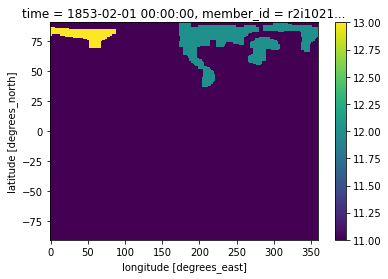

[11. 12. 13.]
[30.]


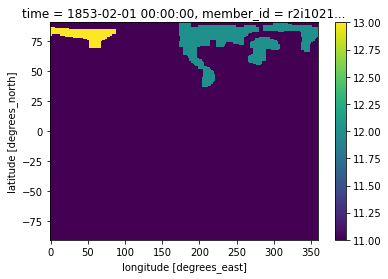

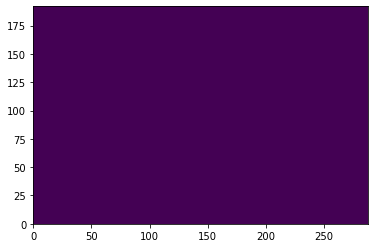

In [206]:
labels[timestep,:,:].plot.imshow(); plt.show()
print(np.unique(labels[timestep,:,:]))

bad_labels = np.unique(stacked[stacked.notnull()])
print(bad_labels)
labels[timestep,:,:].plot.imshow(); plt.show()

plt.pcolor(replace[timestep])

In [160]:
sub_labels = _get_labels(all_timesteps)
sub_labels = xr.DataArray(sub_labels, dims=all_timesteps.dims, coords=all_timesteps.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

# The labels are repeated each time step, therefore we relabel them to be consecutive
for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values
sub_labels_wrapped = _wrap(sub_labels)

centroid = []
for s in np.arange(0, sub_labels_wrapped.shape[0]):
    lx = sub_labels_wrapped.isel(time=s)
    east = lx.where(lx.lon < 180, drop=True)
    east['lon'] = np.arange(360.125, 540.125, 1.25) # this value is related to your grid resolution
    # east['lon'] = np.arange(360.125, 540.125, .25)
    append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
    centroid.append(_get_centroids(append_east))

print(centroid)

[[(32.5130890052356, 340.0)], [(-1.4136125654450267, 360.125), (57.95811518324607, 293.75)], [(-0.4712041884816759, 358.75), (82.46073298429319, 402.625)], [(-0.4712041884816759, 358.75), (80.57591623036649, 403.875)], [(-1.4136125654450267, 358.75), (79.63350785340315, 407.625)], [(-1.4136125654450267, 358.75), (79.63350785340315, 411.375)], [(-4.240837696335079, 362.625), (77.74869109947645, 305.0)], [(-1.4136125654450267, 358.75), (81.51832460732984, 412.625)], [(0.4712041884816749, 360.125)], [(-0.4712041884816759, 358.75), (69.26701570680628, 375.125)]]


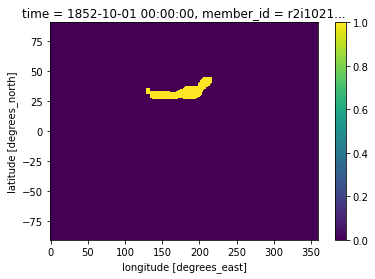

<xarray.DataArray 'lon' (lon: 144)>
array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,  10.  ,
        11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,  20.  ,  21.25,
        22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,  30.  ,  31.25,  32.5 ,
        33.75,  35.  ,  36.25,  37.5 ,  38.75,  40.  ,  41.25,  42.5 ,  43.75,
        45.  ,  46.25,  47.5 ,  48.75,  50.  ,  51.25,  52.5 ,  53.75,  55.  ,
        56.25,  57.5 ,  58.75,  60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,
        67.5 ,  68.75,  70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,
        78.75,  80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75, 100.  ,
       101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75, 110.  , 111.25,
       112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75, 120.  , 121.25, 122.5 ,
       123.75, 125.  , 126.25, 127.5 , 128.75, 130.  , 131.25, 132.5 , 133.75,
       135.  , 1

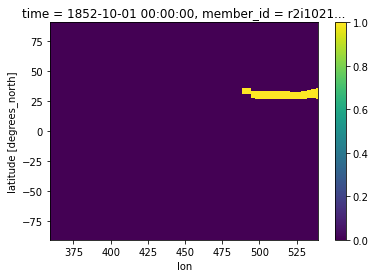

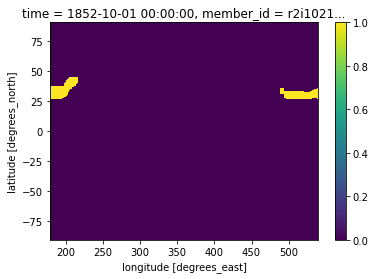

[(32.5130890052356, 340.0)]


In [143]:
lx = sub_labels_wrapped.isel(time=0)
lx.plot.imshow()
plt.show()
east = lx.where(lx.lon < 180, drop=True)
print(east['lon'])
east['lon'] = np.arange(360, 540, 1.25)
print(east['lon'])
append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
print('*******')
print(append_east)
east.plot.imshow()
plt.show()
append_east.plot.imshow()
plt.show()
value = _get_centroids(append_east)
print(value)

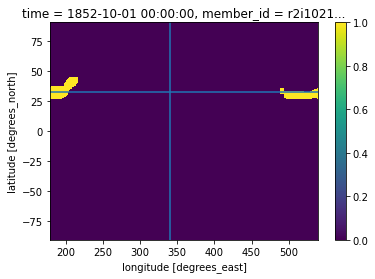

[(32.5130890052356, 340.0)]


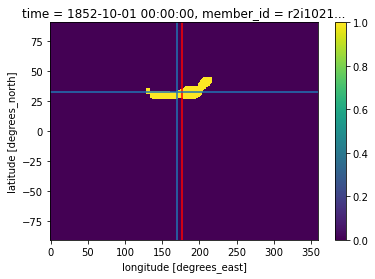

In [141]:
append_east.plot.imshow()
plt.axvline(x=340)
plt.axhline(y=32.5130890052356)
plt.show()
value = _get_centroids(append_east)
print(value)

sub_labels_wrapped[0].plot.imshow()
plt.axvline(x=340/2)
plt.axvline(x=177,c='red')

plt.axhline(y=32.5130890052356)
# plt.show()
# value = _get_centroids(append_east)
# print(value)

In [69]:
x_val = list(zip(*centroid[1]))[0]
print(x_val)
y_val = list(zip(*centroid[1]))[1]
print(y_val)

(-1.4136125654450267, 57.95811518324607)
(0.25, 293.75)


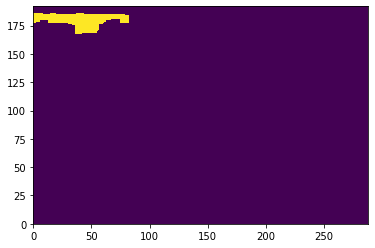

In [150]:
plt.pcolor(sub_labels_wrapped[5,:,:])
# plt.scatter(centroid[0][0][1],centroid[0][0][0])


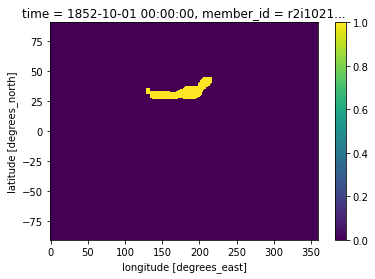

In [115]:
sub_labels = _get_labels(all_timesteps)
sub_labels = xr.DataArray(sub_labels, dims=all_timesteps.dims, coords=all_timesteps.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

# The labels are repeated each time step, therefore we relabel them to be consecutive
for p in range(1, sub_labels.shape[0]):
    sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values
    
sub_labels_wrapped = _wrap(sub_labels)
sub_labels_wrapped[0].plot.imshow()
# centroid = []
# for s in np.arange(0, sub_labels_wrapped.shape[0]):
#     lx = sub_labels_wrapped.isel(time=s)
#     east = lx.where(lx.lon < 180, drop=True)
#     east['lon'] = np.arange(360.125, 540.125, 1.25)
#     append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
#     centroid.append(_get_centroids(append_east))
# print(centroid)
# plt.pcolor(sub_labels[0,:,:])
# plt.show()

# sub_labels_wrapped = _wrap(sub_labels)
# plt.pcolor(sub_labels_wrapped[0,:,:])
# plt.show()

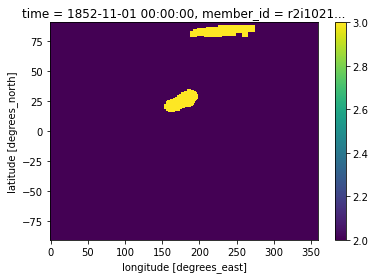

In [107]:
sub_labels_wrapped[1].plot.imshow()
props = regionprops(sub_labels.astype('int'))


[(-1.4136125654450267, 178.75), (57.95811518324607, 207.5)]


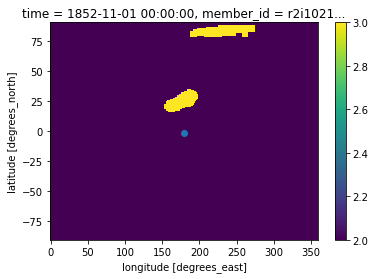

In [103]:
sub_labels = sub_labels_wrapped[1]

props = regionprops(sub_labels.astype('int'))
centroids = [(float(sub_labels.lat[round(p.centroid[0])].values),float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
print(centroids)

sub_labels.plot.imshow()
plt.scatter(centroids[0][1], centroids[0][0])
plt.show()

In [102]:
for i in range(0,len(centroids)):
    print(centroids[i])
    print(centroids[i][1])
    if centroids[i][1] >= 359.875:
        centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.875)
print(centroids)

(32.5130890052356, 177.5)
177.5
[(32.5130890052356, 177.5)]


In [110]:
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values),
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    # for i in range(0,len(centroids)):
    #     if centroids[i][1] >= 359.875:
    #         centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.875)
    return centroids

centroid = []
for s in np.arange(0, sub_labels_wrapped.shape[0]):
    lx = sub_labels_wrapped.isel(time=s)
    east = lx.where(lx.lon < 180, drop=True)
    east['lon'] = np.arange(360.125, 540.125, 1.25)
    # east['lon'] = np.arange(360.125, 540.125, .25)
    append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
    centroid.append(_get_centroids(append_east))

print(centroid)

[[(32.5130890052356, 340.0)], [(-1.4136125654450267, 360.125), (57.95811518324607, 293.75)], [(-0.4712041884816759, 358.75), (82.46073298429319, 402.625)], [(-0.4712041884816759, 358.75), (80.57591623036649, 403.875)], [(-1.4136125654450267, 358.75), (79.63350785340315, 407.625)], [(-1.4136125654450267, 358.75), (79.63350785340315, 411.375)], [(-4.240837696335079, 362.625), (77.74869109947645, 305.0)], [(-1.4136125654450267, 358.75), (81.51832460732984, 412.625)], [(0.4712041884816749, 360.125)], [(-0.4712041884816759, 358.75), (69.26701570680628, 375.125)]]


In [ ]:
sub_labels = _get_labels(image)
# plt.pcolor(blobs_labels)
# plt.colorbar()
# plt.show()
# print(blobs_labels)
# sub_labels = blobs_labels

In [ ]:
sub_labels = xr.DataArray(sub_labels, dims=image.dims, coords=image.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

In [ ]:
wrapped_labels = _wrap(sub_labels)

In [ ]:
labels = sub_labels
# first_column = labels[..., 0]

In [20]:
def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels

def _wrap(labels):
    ''' Impose periodic boundary and wrap labels, then reorder the labels'''
    first_column = labels[..., 0]
    last_column = labels[..., -1]

    stacked = first_column.stack(z=['time','lat'])
    unique_first = np.unique(stacked[stacked.notnull()])

    # This loop iterates over the unique values in the first column, finds the location of those values in 
    # the first columnm and then uses that index to replace the values in the last column with the first column value
    for i in enumerate(unique_first):
        first = np.where(first_column == i[1])
        last = last_column[first[0], first[1]]
        stacked = last.stack(z=['time','lat'])
        bad_labels = np.unique(stacked[stacked.notnull()])
        replace = np.isin(labels, bad_labels)
        labels = labels.where(replace==False, other=i[1])

    labels = labels.fillna(0)
    labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    labels_wrapped = xr.DataArray(labels_wrapped, dims=labels.dims, coords=labels.coords)

    return labels_wrapped

In [ ]:
centroids = _get_centroids(wrapped_labels)
centroids

In [36]:
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values),
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    for i in range(0,len(centroids)):
        if centroids[i][1] >= 359.875:
            centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.875)
    return centroids

def _wrap(labels):
    ''' Impose periodic boundary and wrap labels, then reorder the labels'''
    first_column = labels[..., 0]
    last_column = labels[..., -1]

    stacked = first_column.stack(z=['time','lat'])
    unique_first = np.unique(stacked[stacked.notnull()])

    # This loop iterates over the unique values in the first column, finds the location of those values in 
    # the first columnm and then uses that index to replace the values in the last column with the first column value
    for i in enumerate(unique_first):
        first = np.where(first_column == i[1])
        last = last_column[first[0], first[1]]
        stacked = last.stack(z=['time','lat'])
        bad_labels = np.unique(stacked[stacked.notnull()])
        replace = np.isin(labels, bad_labels)
        labels = labels.where(replace==False, other=i[1])

    labels = labels.fillna(0)
    labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    labels_wrapped = xr.DataArray(labels_wrapped, dims=labels.dims, coords=labels.coords)

    return labels_wrapped

In [ ]:
np.arange(360.125, 540.125, 1.25).shape

In [ ]:
plt.pcolor(sub_labels[0,:,:].values)
plt.colorbar()
plt.show()

In [ ]:
sub_labels = xr.DataArray(sub_labels, dims=image.dims, coords=image.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

# The labels are repeated each time step, therefore we relabel them to be consecutive
sub_labels[:,:] = sub_labels[:,:].values + sub_labels[p-1,:,:].max().values

sub_labels_wrapped = _wrap(sub_labels)
# sub_labels_wrapped.isel(time=1)
# east = lx.where(lx.lon < 180, drop=True)
# east.shape
# east['lon'] = np.arange(360.125, 540.125, 1.25)
# append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
# _get_centroids(append_east)
#     mhw = _get_intensity_area(event, ssta, mhw)

centroid = []
for s in np.arange(0, sub_labels_wrapped.shape[0]):
    lx = sub_labels_wrapped.isel(time=s)
    east = lx.where(lx.lon < 180, drop=True)
    east['lon'] = np.arange(360.125, 540.125, 1.25)
    # east['lon'] = np.arange(360.125, 540.125, .25)
    append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")
    centroid.append(_get_centroids(append_east))
    # mhw['centroid'].append(centroid)

In [ ]:
centroid

In [ ]:
for_one_mhw = SSTA_and_events.where(SSTA_and_events.labels==mhw_id, drop=False)
mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
first_timestep = mhw_when[0][0]
image = for_one_mhw.labels[first_timestep,:,:]
plt.pcolor(image)
plt.colorbar()
plt.show()
image = [image == mhw_id][0]
image_flt = img_as_float(image.copy())
plt.pcolor(image_flt)
plt.colorbar()
plt.show()

In [ ]:
######## Not necessary to run this cell
# previously 

# took about 36 minutes
initialization_SSTA_ar = np.zeros((no_mhws,192,288))
duration_ar = np.zeros((no_mhws))
initialization_when_ar = np.zeros((no_mhws))

for mhw_id in range(1,no_mhws): # no_mhws  
    for_one_mhw = SSTA_and_events.where(SSTA_and_events.labels==mhw_id, drop=False)
    
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    initialization_when_ar[mhw_id] = first_timestep
    initialization_SSTA_ar[mhw_id,:,:] = for_one_mhw.SSTA[first_timestep,:,:].values
    
    duration = calc_duration(SSTA_and_events, mhw_id)
    duration_ar[mhw_id] = duration
    
# np.save('initialization_SSTA_ar_0.npy', initialization_SSTA_ar)    
# initialization_SSTA_ar_0 = np.load('initialization_SSTA_ar_0.npy')

# np.save('duration_ar_0.npy', duration_ar)    
# duration_ar_0 = np.load('duration_ar_0.npy')

# np.save('initialization_when_ar_0.npy', initialization_when_ar)    
# initialization_when_ar_0 = np.load('initialization_when_ar_0.npy')

initialization_SSTA_ar_0 = np.load('initialization_SSTA_ar_0.npy')
duration_ar_0 = np.load('duration_ar_0.npy')
initialization_when_ar_0 = np.load('initialization_when_ar_0.npy')

In [13]:
# functions
def number_of_mhws(event_file):
    return len(np.unique(event_file.labels)) - 1

def calc_duration(event_file, mhw_id):
    return len(event_file.where(event_file.labels==mhw_id, drop=True).time)

def calc_cumulativeintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    cumulative_intensity = np.nansum(for_one_mhw.SSTA)
    cumulative_intensity_monthly = for_one_mhw.SSTA.sum(axis=(1,2)).values
    return cumulative_intensity, cumulative_intensity_monthly

def calc_meanintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    mean_intensity = np.nanmean(for_one_mhw.SSTA)
    mean_intensity_monthly = for_one_mhw.SSTA.mean(axis=(1,2)).values
    return mean_intensity, mean_intensity_monthly

def calc_maximumintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    max_intensity = np.nanmax(for_one_mhw.SSTA)
    max_intensity_monthly = for_one_mhw.SSTA.max(axis=(1,2)).values
    return max_intensity, max_intensity_monthly

def calc_stdintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    std_intensity = np.nanstd(for_one_mhw.SSTA)
    std_intensity_monthly = for_one_mhw.SSTA.std(axis=(1,2)).values
    return std_intensity, std_intensity_monthly

def calc_spatialextent(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    spatial_extents = []
    coords_full = []
    for i in range(len(for_one_mhw.time)):
        for_onetimestep_stacked = for_one_mhw.labels[i,:,:].stack(zipcoords=['lat','lon'])
        intermed = for_onetimestep_stacked[for_onetimestep_stacked.notnull()].zipcoords.values
        lats = [x[0] for x in intermed]; lons = [x[1] for x in intermed]
        coords = list(zip(lats, lons))
        coords_full.append(coords)
        y,x=zip(*coords)
        dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]; dlat = (110.574 *1) * np.ones(len(dlon))
        area = np.sum(dlon*dlat)
        spatial_extents.append(area)
    max_spatial_extent = np.max(spatial_extents)
    max_spatial_extent_time = np.argmax(spatial_extents)
    mean_spatial_extent = np.mean(spatial_extents)
    cumulative_spatial_extent = np.sum(spatial_extents)
    return coords_full, spatial_extents, max_spatial_extent, max_spatial_extent_time, mean_spatial_extent, cumulative_spatial_extent

def initialization(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    bymonth = np.resize(np.arange(1,13),12*166)[1:-11]
    month = bymonth[first_timestep]
    return first_timestep, for_one_mhw.SSTA[first_timestep,:,:].values, month

from skimage.measure import find_contours
from haversine import haversine, Unit
from scipy.interpolate import interp1d

def calc_perimeter(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    first_timestep, first_array, month = initialization(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)

    convert_long_range = interp1d([0,360],[-180,180])
    perimeter_ls = []
    for i in timesteps_to_choose_from:
        bw = for_one_mhw.labels[i,:,:].values > 0
        contours = find_contours(bw)
        distance_ls = []
        for contour_num in range(len(contours)):
            latitudes = for_one_mhw.lat.values[contours[contour_num][:,0].astype(int)]
            longitudes = for_one_mhw.lon.values[contours[contour_num][:,1].astype(int)]    
            coords = list(zip(latitudes, convert_long_range(longitudes)))

            for i in range(len(coords)-1):
                distance = haversine(coords[i], coords[i+1],Unit.KILOMETERS)
                distance_ls.append(distance)
            distance_ls.append(haversine(coords[len(coords)-1], coords[0],Unit.KILOMETERS))
        perimeter = np.sum(distance_ls)
        perimeter_ls.append(perimeter)
    return perimeter_ls  

def calc_percperimetervsarea(spatial_extents, perimeters):
    return (np.asarray(perimeters)/np.asarray(spatial_extents))*100

def convert_from_timeres_to_months(time_step):
    bymonth = np.resize(np.arange(1,13),12*166)[1:-11]
    month = bymonth[first_timestep]
    return month

def calc_compltodeform(coords_full, spatial_extents):
    perc_sharedarea_ls = []
    for i in range(len(coords_full)-1):
        a_set = set(coords_full[i])
        b_set = set(coords_full[i+1])
        if a_set & b_set:
            coords = a_set & b_set
            y,x=zip(*coords)
            dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]; dlat = (110.574 *1) * np.ones(len(dlon))
            sharedarea = np.sum(dlon*dlat)
            perc_sharedarea_ls.append((sharedarea/ (spatial_extents[i] + spatial_extents[i+1]))*100)
        else:
            sharedareaarea = 0
            perc_sharedarea_ls.append((sharedarea/ (spatial_extents[i] + spatial_extents[i+1]))*100)
    return perc_sharedarea_ls

def calc_deform(perc_sharedarea_ls):
    return np.asarray(100 - np.asarray(perc_sharedarea_ls))

def calc_whenlargesmall(spatial_extents):
    when_large = (np.argmax(spatial_extents) / len(spatial_extents))*100
    when_small = (np.argmin(spatial_extents) / len(spatial_extents))*100
    return when_large, when_small

def cross_correlation_spat(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    first_timestep, first_array, month = initialization(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    cc_image_array = np.zeros((len(timesteps_to_choose_from), 192,288))    

    for i in range(len(timesteps_to_choose_from[:-1])):
        image = for_one_mhw.SSTA[timesteps_to_choose_from[i],:,:].values
        image = np.nan_to_num(image)
        offset_image = for_one_mhw.SSTA[timesteps_to_choose_from[i+1],:,:].values
        offset_image = np.nan_to_num(offset_image)
        image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
        cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
        cc_image_array[i,:,:] = np.real(cc_image)
    return cc_image_array

from skimage.morphology import convex_hull_image
from skimage import img_as_float

def perc_imoverchull(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    perc_imoverchull_ls = []
    for i in range(len(for_one_mhw.time)):
        image = for_one_mhw.labels[i].values
        image = [image == mhw_id][0]
        chull = convex_hull_image(image)
        chull_asflt = img_as_float(chull.copy())
        image_asflt = img_as_float(image.copy())
        perc_imoverchull = np.sum(image_asflt)/np.sum(chull_asflt)*100
        perc_imoverchull_ls.append(perc_imoverchull)
    return perc_imoverchull_ls